In [1]:
import geopandas as gpd
from osgeo import ogr
import pandas as pd
import tifffile as tiff #needed for the tif data for perry county
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from math import sin, cos, sqrt, atan2, radians
import sys
from shapely.geometry import Polygon, box, Point, LineString, MultiLineString
import pickle
import gurobipy as gp
from gurobipy import GRB
import tifffile as tiff #needed for the tif data for perry county
import xlwt
from xlwt import Workbook
from shapely.ops import snap, split, nearest_points
#from shapely.geometry import MultiPoint, LineString
#from dbfread import DBF
import osmnx as ox
import networkx as nx
import math
import gurobipy as gp
from gurobipy import GRB
import os

In [2]:
os.chdir("/Users/yuelanzhu/Downloads/Research/my code file")

In [3]:
# calculate distance
def haversinedist(lat1, lon1, lat2, lon2):
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance * 1000

In [4]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'

In [5]:
building_coords = readClusterFile(clusterfile)

In [6]:
#convert data to dataframe
df = pd.DataFrame(building_coords,
                  columns = ['longitude','latitude','elevation'])

In [7]:
#check # of null
df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(building_coords))

longitude    0.0
latitude     0.0
elevation    0.0
dtype: float64

In [8]:
# cluster, n_clusters is from table 2 in paper draft, using ward-tree
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=100, affinity='euclidean', linkage='ward')
cluster.fit_predict(building_coords[:,1:2])

array([46, 94, 60, ..., 92, 15, 64])

In [9]:
# add cluster to dataframe
df['cluster.labels_'] = cluster.labels_.tolist()

In [10]:
# select highest and lowest nodes in cluster
tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)

In [11]:
# creat MST

graph = []
mstree = []
def createMSTnx(dataframe):
    #only takes longitude and latitude from the cluster data, note we also have elevation and stuff there too
    #coordinates = twoDcluster
    for k in range(10):
        cluster = dataframe[dataframe['cluster.labels_'] == k]
        cluster = cluster[['longitude','latitude']]
        latlon = cluster.to_numpy()
        nrows, ncols = latlon.shape
        #creates graph
        graph.append(nx.Graph())
        weights = []
        #distance in km as weight between each point in the graph
        for i in range(nrows):
            graph[k].add_node(i,pos=(latlon[i,0],latlon[i,1]))
            for j in range(i+1,nrows):
                dist = haversinedist(latlon[i,1], latlon[i,0], latlon[j,1], latlon[j,0])
                weights.append(dist)
                graph[k].add_edge(i,j, weight = dist)
        #creates MST
        mstree.append(nx.minimum_spanning_tree(graph[k]))
    return mstree, graph

In [12]:
createMSTnx(df)

([<networkx.classes.graph.Graph at 0x7fa8249144c0>,
  <networkx.classes.graph.Graph at 0x7fa8248e3ca0>])

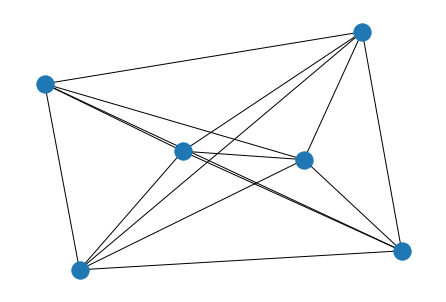

In [13]:
# draw a simulation of graph

nx.draw(graph[9])

In [14]:
m = gp.Model('pipe and pump distribution')
m.Params.timeLimit = 12000

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-18
Set parameter TimeLimit to value 12000


In [15]:
# pipe parameters
pipesize = [0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6]
pipesize_str, pipecost = gp.multidict({'0.05': 8.7, '0.06': 9.5, '0.08': 11, \
                                                   '0.1': 12.6, '0.15': 43.5,'0.2': 141, '0.25': 151, '0.3': 161, '0.35':230, '0.4': 246, '0.45':262, 
                                                   '0.5':292, '0.6':315})

In [16]:
# pump parameters
# power in kW, default value from Matlab document
pumptype = [2, 5, 800]
# efficiency corresponding to power
pump_eff = [0.8, 0.9, 0.9]

In [17]:
# find label of tank node in cluster
tank_lon = str(tank[tank['cluster.labels_'] == 9][['longitude']].iat[0,0])
tank_lat = str(tank[tank['cluster.labels_'] == 9][['latitude']].iat[0,0])
for i in mstree[9].nodes():
    if str(mstree[9].nodes[i]['pos'][0]) == tank_lon and str(mstree[9].nodes[i]['pos'][1]) == tank_lat:
        tank_node = i

In [18]:
tank_node

3

In [19]:
# set variables

# binary variable indicating if at edge n pipe of type t is implemented
arc_sizes = m.addVars(mstree[9].edges(), pipesize, vtype = GRB.BINARY, name = "DIAMETER")

# continuous variable indicating flow through edge n.
q = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "FLOW")

# continuous variable indicating inflow and outflow for each node
qin = m.addVars(mstree[9].nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "INFLOW")
qout = m.addVars(mstree[9].nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "OUTFLOW")

# binary variable indicating if at edge n the pump of type j is implemented.
arc_pumps = m.addVars(mstree[9].edges(),pumptype, vtype = GRB.BINARY, name = "PUMP")

#continuous variable representing the pressure injected by the pump at edge n.
pr = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")

#continuous variable representing the head pressure at node i
H = m.addVars(mstree[9].nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")

#pipe elevations at node i 
e = m.addVars(mstree[9].nodes(), vtype = GRB.CONTINUOUS, name = 'In Node Elevation')

# area of section of pipe of diameter dt
A = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "pipe area")

# head pressure loss for edge n
loss = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "loss")

# just a calculated item used to avoid bug
item = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "item")

In [20]:
#node elevation excavation in meters
#upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
#a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
cluster9 = df[df['cluster.labels_'] == 9]
cluster9_elv = cluster9[['elevation']]
elevation_ub = dict()
elevation_lb = dict()
for i in range(mstree[9].number_of_nodes()):
    elevation_ub[i] = cluster9_elv.iloc[[i]] - 0.3048
    elevation_lb[i] = cluster9_elv.iloc[[i]] - 30

In [21]:
innode = {}
outnode = {}
for i,j in mstree[9].edges():
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank
        innode.setdefault(i, [])
        innode[i].append(j)
        outnode.setdefault(j, [])
        outnode[j].append(i)
    else:
        # if node i is nearer to tank
        innode.setdefault(j, [])
        innode[j].append(i)
        outnode.setdefault(i, [])
        outnode[i].append(j)

In [22]:
for i in qin:
    innode.setdefault(i,[])
    outnode.setdefault(i, [])

In [23]:
qin

{0: <gurobi.Var *Awaiting Model Update*>,
 1: <gurobi.Var *Awaiting Model Update*>,
 2: <gurobi.Var *Awaiting Model Update*>,
 3: <gurobi.Var *Awaiting Model Update*>,
 4: <gurobi.Var *Awaiting Model Update*>,
 5: <gurobi.Var *Awaiting Model Update*>}

In [24]:
list(mstree[9].edges)[0][0]

0

In [25]:
q

{(0, 1): <gurobi.Var *Awaiting Model Update*>,
 (1, 2): <gurobi.Var *Awaiting Model Update*>,
 (1, 3): <gurobi.Var *Awaiting Model Update*>,
 (3, 4): <gurobi.Var *Awaiting Model Update*>,
 (4, 5): <gurobi.Var *Awaiting Model Update*>}

In [26]:
mstree[9].edges

EdgeView([(0, 1), (1, 2), (1, 3), (3, 4), (4, 5)])

In [27]:
dist1 = []
dist2 = []
for i,j in mstree[9].edges():
    # split graph at tank node
    if i < tank_node:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=j))
            dist1.append(dist)         
        else: # if node j is nearer to tank
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=i))
            dist1.append(dist) 
                      
    else:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=j))
            dist2.append(dist)
        else:
            dist = len(nx.shortest_path(mstree[9],source=tank_node, target=i))
            dist2.append(dist)

In [28]:
dist1

[3, 3, 2]

In [29]:
dist2

[2, 3]

In [30]:
innode

{0: [1], 2: [1], 1: [3], 4: [3], 5: [4], 3: []}

In [31]:
outnode

{1: [0, 2], 3: [1, 4], 4: [5], 0: [], 2: [], 5: []}

In [32]:
def d(d):
    d = len(nx.shortest_path(mstree[9],source=tank_node, target=d))
    return d

In [33]:
m.addConstr(q[3,4]==q[4,5]+0.9464)
m.addConstr(q[1,3]==q[0,1]+q[1,2]+0.9464)
m.addConstr(q[0,1]>=0.9464)
m.addConstr(q[1,2]>=0.9464)
m.addConstr(q[4,5]>=0.9464)

<gurobi.Constr *Awaiting Model Update*>

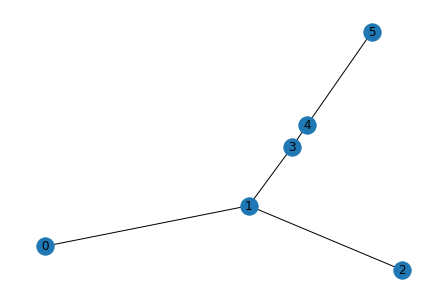

In [34]:
# draw a simulation of MST

nx.draw(mstree[9],with_labels = True)

In [35]:
#creat dir dict i->j

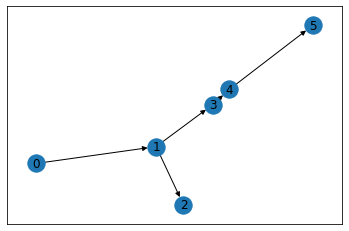

In [50]:
nx.draw_networkx(mstree[9], arrows=True)

In [54]:
[x for x in mstree[9].nodes() if mstree[9].out_degree(x)==0]

AttributeError: 'Graph' object has no attribute 'out_degree'

In [36]:
for i,j in mstree[9].edges():
    if i < tank_node:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=j))==max(dist1):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i))==max(dist1):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        else: 
            m.addConstr(sum(q[i,m] for m in innode[i] if d(i)>d(m))==
                        sum(q[i,k] for k in outnode[i] if d(i)<d(k) and k>i) #q[1,0]
                        +sum(q[k,i] for k in outnode[i] if d(i)>d(k)))
                        
                                
    else:
        if len(nx.shortest_path(mstree[9],source=tank_node, target=j))==max(dist2):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        if len(nx.shortest_path(mstree[9],source=tank_node, target=i))==max(dist2):
            m.addConstr(q[i,j]>=0.9464, "water demand at leave nodes")
        

for i in qin:
    n = []
    n.append(
        len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > 
        len(nx.shortest_path(mstree[9],source=tank_node, target=j)))
    m.addConstr(sum(q[i,j] for j in n
    
    m.addConstr(sum(q[i,j] for i,j in mstree[9].edges() and 
                    len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > 
                    len(nx.shortest_path(mstree[9],source=tank_node, target=j)))
                == sum(q[i,j] for i,j in mstree[9].edges() and 
                    len(nx.shortest_path(mstree[9],source=tank_node, target=i)) <
                    len(nx.shortest_path(mstree[9],source=tank_node, target=j)))
                + 0.9464, "water demand")

In [37]:
# add constraints

for i in qin:
    #qin− qout = daily water demand for each node
    #m.addConstr(qin[i]-qout[i] >= 0.9464, "water demand")# assume 250 gpd, covert it to 0.9464 m3/h
    m.addConstr(H[i] >= 68.9476, "Min head pressure") #10 psi, covert it to kpa
    m.addConstr(H[i] <= 551.581, "Max head pressure") #80 psi, covert it to kpa  
    
    # pipe elevation must be betwenn lb and ub
    m.addConstr(e[i] >= float(str(elevation_lb[i])[20:]))
    m.addConstr(e[i] <= float(str(elevation_ub[i])[20:]))

for i,j in mstree[9].edges():
    
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank
        # define q[i,j] based on qin and qout
        linkqin = []
        keys = [*range(0, len(qin), 1)]
        values = [0]*len(qin)
        for a, b in mstree[9].edges():
            if a==i:
                linkqin.append(qin[b]) 
                values[a]=sum(linkqin)
        m.addConstr(qout[i] == values[i])
        m.addConstr(q[i,j] == qout[i])
        qoutsum = dict(zip(keys, values))

In [38]:
for i,j in mstree[9].edges():
    
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank        
        # Pipe slope must be greater than 1%, or a pump station is used
        m.addConstr(
            ((1-arc_pumps.sum(i, j, '*'))*0.01 <= (e[i] - e[j]) / mstree[9][i][j]["weight"]), 
            ("slope max" + '[' + str(i) + ',' + str(j)+ ']'))

    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank       
        # Pipe slope must be greater than 1%, or a pump station is used
        m.addConstr(
            ((1-arc_pumps.sum(i, j, '*'))*0.01 <= (e[j] - e[i]) / mstree[9][i][j]["weight"]), 
            ("slope max" + '[' + str(i) + ',' + str(j)+ ']'))
    
    #only one pipe per edge
    m.addConstr((arc_sizes.sum(i, j, '*') == 1.0), "single size chosen")
    #only one pump per edge
    m.addConstr((arc_pumps.sum(i, j, '*') <= 1.0), "single type chosen")
    
    # Velocity must be between 0.6 and 3 m/s to 30
    #m.addConstr((
    #q[i,j] <= ((3.14/8)*gp.quicksum(arc_sizes[i,j,k]*k**2 for k in pipesize)) * 10), "Velocity Max Constr")
    m.addConstr((
    q[i,j] >= ((3.14/8)*gp.quicksum(arc_pumps[i,j,k]*k**2 for k in pumptype)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    
    # injected pressure pr[i,j] must be less than the capacity of pump.
    m.addConstr((
        pr[i,j]*q[i,j]*(9.80665*1000) <= 
        gp.quicksum(arc_pumps[i,j,k]*k*pump_eff[pumptype.index(k)] for k in pumptype)), 
        "pressure by pump less than the capacity")
    
    # conservation of Head at edge n, use Hazen Williams equation
    m.addConstr(A[i,j] == 3.14/4*gp.quicksum(arc_sizes[i,j,k]*k for k in pipesize))
    f = 0.3
    m.addConstr(item[i,j]*2*9.80665*A[i,j]==q[i,j]*q[i,j])
    m.addConstr(loss[i,j] == (gp.quicksum(arc_sizes[i,j,k]/k for k in pipesize))*f*mstree[9][i][j]["weight"]*item[i,j])#(q[i,j])**2/(2*9.80665*A[i,j]))
    m.addConstr((H[i]-H[j]==loss[i,j]-pr[i,j]),"conservation of Head")

# add constraints

for i,j in mstree[9].edges():
    
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank
        # define q[i,j] based on qin and qout
        linkqin = []
        for a, b in mstree[9].edges():
            if b==j:
                linkqin.append(qin[a])
        m.addConstr(qout[j] == qoutsum[j]+sum(linkqin))
        m.addConstr(q[i,j] == qout[j])

In [39]:
excavation = 25
bedding_cost_sq_ft = 6
capital_cost_pump_station = 0
ps_flow_cost = 0
ps_OM_cost = 2795
hometreatment = 5500
#water_spec_weight = 9.8
fixed_treatment_cost = 10000
#kwh_hour = 0.114
collection_om = 209

In [40]:
# set obective function

# pipe cost
obj1 = gp.quicksum(mstree[9][i][j]["weight"] * gp.quicksum(pipecost[str(k)] * arc_sizes[i, j, k] 
                                                           for k in pipesize) for i,j in mstree[9].edges())

# Capital cost of pump stations
obj2 = gp.quicksum(arc_pumps.sum(i, j, '*') * capital_cost_pump_station  for i,j in mstree[9].edges())

#Operation and maintenance costs
obj3 = gp.quicksum(arc_pumps.sum(i, j, '*')*ps_OM_cost for i, j in mstree[9].edges())

# cost of exaction and bedding for all installed collection systems pipes
obj4 = ((1 + gp.quicksum(arc_sizes[i,j,k]*k for k in pipesize)*0.01) * mstree[9][i][j]["weight"] 
        * bedding_cost_sq_ft + excavation * \
        (1 + gp.quicksum(arc_sizes[i,j,k]*k for k in pipesize)*0.01) * mstree[9][i][j]["weight"] * 0.5
        * ((elevation_ub[i] - e[i]) + (elevation_ub[j] - e[j]))
        for i, j in mstree[9].edges())

# cost of elevated base (in $/meter)=1
obj5 = gp.quicksum(H[i] for i in mstree[9].nodes())

obj = obj1 + obj2 + obj3 +obj5#+ obj4 

In [41]:
m.setObjective(obj, GRB.MINIMIZE)

In [42]:
#m.params.NonConvex = 2

In [43]:
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64 rows, 129 columns and 254 nonzeros
Model fingerprint: 0x45eb19f6
Model has 15 quadratic constraints
Variable types: 49 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [7e-04, 2e+05]
  QMatrix range    [1e+00, 1e+04]
  QLMatrix range   [1e+00, 7e+02]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 6e+02]
Presolve removed 2 rows and 13 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [44]:
m.status

3

In [45]:
# water demand
# max velocity
# R11
# these 3 constrs are output of IIS

In [46]:
status = m.status
if status == GRB.Status.OPTIMAL:
    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))
    print('Obj: %g' % m.objVal)
       
elif status == GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)
    # do IIS
    m.computeIIS()
    m.write("m.ilp")
    gp.read("m.ilp")
    for c in m.getConstrs():
        if c.IISConstr:
            print('%s' % c.constrName)

Optimization was stopped with status 3

Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0        79         -         0        49         -           0s
        3         3         -         0         0         -           0s

IIS computed: 3 constraints, 0 bounds
IIS runtime: 0.01 seconds (0.00 work units)
Read LP format model from file m.ilp
Reading time = 0.00 seconds
: 3 rows, 3 columns, 6 nonzeros
R1
water demand at leave nodes
R7


In [47]:
m.update()
copy = m.copy()

In [48]:
 if m.status == GRB.INFEASIBLE:
    vars = copy.getVars()
    ubpen = [1.0]*copy.numVars
    copy.feasRelax(1, False, vars, None, ubpen, None, None)
    copy.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 144 rows, 209 columns and 414 nonzeros
Model fingerprint: 0x2fd32976
Model has 80 quadratic objective terms
Model has 15 quadratic constraints
Variable types: 129 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [7e-04, 2e+05]
  QMatrix range    [1e+00, 1e+04]
  QLMatrix range   [1e+00, 7e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 6e+02]
Presolve removed 82 rows and 13 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
